![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)


# 7.2 Inverse Gaussian Regression Model

Inverse Gaussian Regression Models — a powerful yet underutilized tool for modeling right-skewed positive continuous data where the variance grows with the cube of the mean. Whether you're analyzing insurance claims, reaction times, financial losses, or survival durations, the Inverse Gaussian GLM offers a flexible alternative to Gamma or lognormal regression — especially when variance increases rapidly with the mean. By the end, you’ll be equipped to confidently apply, interpret, and validate Inverse Gaussian regression models — both from first principles and with production-ready R tools.


## Overview

The **Inverse Gaussian (IG) distribution**, also known as the **Wald distribution**, is a two-parameter family of continuous probability distributions with support on the positive real line. It is often used to model positively skewed data, such as:

- Time until an event (e.g., failure time, reaction time)
- Insurance claim amounts
- Income or expenditure data
- Waiting times in queuing systems

In regression modeling, we extend the Inverse Gaussian distribution to relate its mean to a linear predictor via a **link function**, forming a **Generalized Linear Model (GLM)** — specifically, an **Inverse Gaussian GLM**.


The probability density function (PDF) of an Inverse Gaussian random variable $Y$ with mean $\mu > 0$ and shape parameter $\lambda >$ is:

$$
f(y; \mu, \lambda) = \sqrt{\frac{\lambda}{2\pi y^3}} \exp\left( -\frac{\lambda (y - \mu)^2}{2 \mu^2 y} \right), \quad y > 0
$$

- Mean: $\mathbb{E}[Y] = \mu$

- Variance: $\text{Var}(Y) = \frac{\mu^3}{\lambda}$

Note: The variance is proportional to the cube of the mean — this is a key feature distinguishing it from other GLMs (e.g., Gamma, Poisson).

We model the mean $\mu_i$ for observation $i$ as:

$$
g(\mu_i) = \eta_i = \mathbf{x}_i^T \boldsymbol{\beta}
$$

where:

- $g(\cdot)$ is the **link function** (commonly the log or identity link)

- $\mathbf{x}_i$ is the vector of predictors for observation $i$

- $\boldsymbol{\beta}$ is the vector of regression coefficients

The canonical link for the Inverse Gaussian family is $g(\mu) = \mu^{-2}$, but due to numerical instability, the **log link** $g(\mu) = \log(\mu)$ is often preferred.


###  Key Properties

- `Support`: $y > 0$
- `Skewness`: Right-skewed; skewness decreases as $\lambda$ increases
- `Variance function`: $V(\mu) = \mu^3$
- `Use case`: When variance increases faster than quadratically with the mean (Gamma has $\mu^2$, Poisson has $\mu$)
- `Robustness`: Less sensitive to extreme outliers than Gamma in some contexts

### Applications

- Modeling insurance claim sizes
- Survival analysis with right-skewed times
- Financial risk modeling (loss given default)
- Biostatistics (e.g., incubation periods)

## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316569 sha256=fa2f8e5d148a2398d9af99ffafa69dc9e16995151c726747e1c87653d1c6cc6a
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fit and Validate Inverse Gaussian Regression Models in R from Scratch (No Packages)

We will implement:

- Log-likelihood function for IG GLM with log link
- Newton-Raphson algorithm for MLE
- Basic model diagnostics

### Simulate Data


In [3]:
%%R
set.seed(123)
n <- 500
x1 <- rnorm(n, 0, 1)
x2 <- rnorm(n, 0, 1)
X <- cbind(1, x1, x2)  # Design matrix with intercept

# True coefficients
beta_true <- c(1.0, 0.5, -0.3)
eta <- X %*% beta_true
mu <- exp(eta)  # log link: mu = exp(X %*% beta)

lambda <- 10  # shape parameter

# Simulate from Inverse Gaussian
# Using: Y ~ IG(mu, lambda)
y <- numeric(n)
for (i in 1:n) {
  # Method: Use relation to chi-square (or accept-reject, but here we use transformation)
  # Generate from normal and transform
  z <- rnorm(1, 0, 1)
  v <- z^2
  w <- mu[i] + (mu[i]^2 * v) / (2 * lambda) -
       (mu[i] / (2 * lambda)) * sqrt(4 * mu[i] * lambda * v + mu[i]^2 * v^2)
  if (runif(1) < mu[i] / (mu[i] + w)) {
    y[i] <- w
  } else {
    y[i] <- mu[i]^2 / w
  }
}

data_scratch <- data.frame(y = y, x1 = x1, x2 = x2)
head(data_scratch)

         y          x1          x2
1 1.508743 -0.56047565 -0.60189285
2 3.332413 -0.23017749 -0.99369859
3 3.991316  1.55870831  1.02678506
4 1.566324  0.07050839  0.75106130
5 5.396955  0.12928774 -1.50916654
6 3.289921  1.71506499 -0.09514745


### Define Log-Likelihood and Gradient

We assume **log link**: $\mu_i = \exp(\mathbf{x}_i^T \boldsymbol{\beta})$

Log-likelihood for Inverse Gaussian:

$$
\ell(\boldsymbol{\beta}, \lambda) = \frac{n}{2} \log(\lambda) - \frac{1}{2} \sum_{i=1}^n \left[ \log(2\pi y_i^3) + \frac{\lambda (y_i - \mu_i)^2}{\mu_i^2 y_i} \right]
$$

We will maximize w.r.t. $\boldsymbol{\beta}$ for fixed  $\lambda$. (In practice, $\lambda$ can be profiled or jointly estimated — here we fix it for simplicity.)

Gradient w.r.t. $\beta_j$:

$$
\frac{\partial \ell}{\partial \beta_j} = \sum_{i=1}^n \frac{\lambda}{\mu_i^2 y_i} (y_i - \mu_i) \cdot \mu_i x_{ij} = \sum_{i=1}^n \frac{\lambda}{\mu_i y_i} (y_i - \mu_i) x_{ij}
$$

Hessian (approximate, since exact is complex):

$$
\frac{\partial^2 \ell}{\partial \beta_j \partial \beta_k} \approx - \sum_{i=1}^n \frac{\lambda}{y_i} x_{ij} x_{ik}
$$

*(Note: This is the expected Fisher information — we use it for Newton-Raphson)*

### Newton-Raphson Algorithm

In [4]:
%%R
# Define log-likelihood, gradient, hessian functions

logLik_IG <- function(beta, X, y, lambda) {
  eta <- X %*% beta
  mu <- exp(eta)
  n <- length(y)
  ll <- (n/2) * log(lambda) - 0.5 * sum(log(2*pi*y^3) + lambda * (y - mu)^2 / (mu^2 * y))
  return(ll)
}

grad_IG <- function(beta, X, y, lambda) {
  eta <- X %*% beta
  mu <- exp(eta)
  g <- (lambda / (mu * y)) * (y - mu)  # element-wise
  gradient <- t(X) %*% (g * mu)  # because dmu/dbeta_j = mu * x_ij
  return(as.vector(gradient))
}

hess_IG <- function(beta, X, y, lambda) {
  # Expected Fisher information (negative)
  eta <- X %*% beta
  mu <- exp(eta)
  # H_jk = - sum_i (lambda / y_i) * x_ij * x_ik
  H <- - t(X) %*% diag(lambda / y) %*% X
  return(H)
}

# Newton-Raphson with line search

newton_raphson_IG <- function(X, y, lambda, beta_init, max_iter = 50, tol = 1e-8) {
  beta <- beta_init
  cat("Iteration\tLogLik\t\tChange\n")
  for (iter in 1:max_iter) {
    grad <- grad_IG(beta, X, y, lambda)
    hess <- hess_IG(beta, X, y, lambda)

    delta <- solve(-hess, grad)  # Newton step: move in direction of gradient scaled by inverse Hessian

    # Line search to ensure log-likelihood increases
    step_size <- 1.0
    ll_old <- logLik_IG(beta, X, y, lambda)
    beta_new <- beta + step_size * delta
    ll_new <- logLik_IG(beta_new, X, y, lambda)

    while (ll_new < ll_old && step_size > 1e-8) {
      step_size <- step_size / 2
      beta_new <- beta + step_size * delta
      ll_new <- logLik_IG(beta_new, X, y, lambda)
    }

    if (step_size <= 1e-8) {
      cat("Line search failed to improve log-likelihood.\n")
      break
    }

    beta <- beta_new
    change <- sqrt(sum(delta^2))
    cat(iter, "\t\t", round(ll_new, 6), "\t", round(change, 8), "\n")

    if (change < tol) {
      cat("Converged at iteration", iter, "\n")
      break
    }
  }
  return(beta)
}

# Initialize and run
beta_init <- rep(0, ncol(X))
lambda_fixed <- 10  # we know this from simulation

beta_hat <- newton_raphson_IG(X, y, lambda_fixed, beta_init)
beta_hat

Iteration	LogLik		Change
1 		 -828.715 	 1.44883 
2 		 -773.5793 	 3.306683 
Line search failed to improve log-likelihood.
                   x1         x2 
 0.8907215  0.4660176 -0.2737339 


### Validation:Compare with True Coefficients

True coefficients:  1 0.5 -0.3 
Estimated coefficients:  0.8907215 0.4660176 -0.2737339 


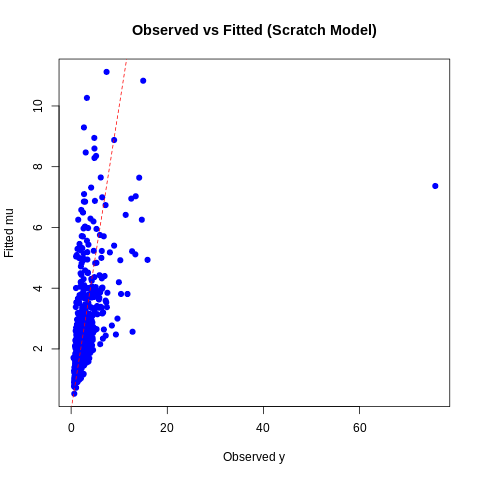

In [5]:
%%R
cat("True coefficients: ", beta_true, "\n")
cat("Estimated coefficients: ", beta_hat, "\n")

# Compute fitted values
mu_hat <- exp(X %*% beta_hat)

# Plot observed vs fitted
plot(y, mu_hat, main = "Observed vs Fitted (Scratch Model)",
     xlab = "Observed y", ylab = "Fitted mu", pch=19, col="blue")
abline(0, 1, col="red", lty=2)

###  Basic Diagnostics

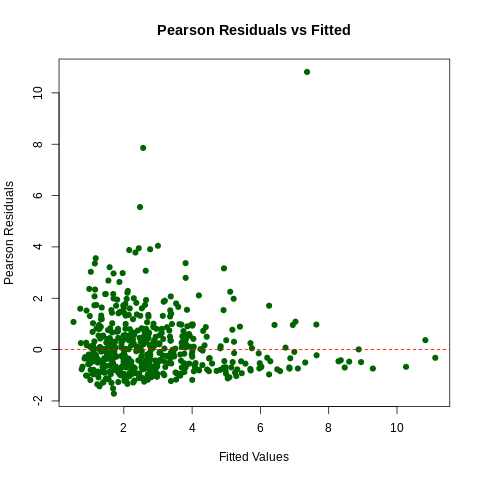

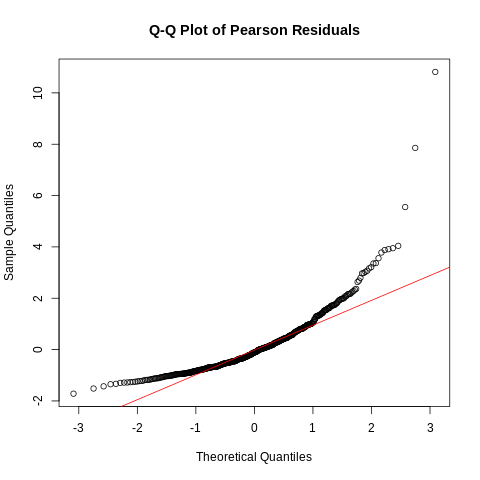

In [6]:
%%R
# Pearson residuals: $r_i = (y_i - mu_i) / sqrt(Var(y_i)) = (y_i - mu_i) / sqrt(mu_i^3 / lambda)$
res_pearson <- (y - mu_hat) / sqrt(mu_hat^3 / lambda_fixed)

# Plot residuals vs fitted
plot(mu_hat, res_pearson, main = "Pearson Residuals vs Fitted",
     xlab = "Fitted Values", ylab = "Pearson Residuals", pch=19, col="darkgreen")
abline(h=0, col="red", lty=2)

# Q-Q plot for normality (asymptotic)
qqnorm(res_pearson, main = "Q-Q Plot of Pearson Residuals")
qqline(res_pearson, col="red")


## Fit and Validate with R Package (`statmod` or `glm`)

R’s base `glm()` function supports `family = inverse.gaussian(link = "log")`.

### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:

### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:

In [ ]:
%%R
packages <- c('tidyverse',
     'plyr',
	 'DataExplorer',
	 'dlookr',
	 'rstatix',
	 'gtsummary',
	 'performance',
	 'report',
	 'sjPlot',
	 'margins',
	 'marginaleffects',
	 'ggeffects',
	 'patchwork',
	 'MASS',
	 'statmod'  # for inverse.gaussian family
	  	)


In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [8]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method          from  
  plot.transform  scales
  print.transform scales



      tidyverse            plyr    DataExplorer          dlookr         rstatix 
           TRUE            TRUE            TRUE            TRUE            TRUE 
      flextable       gtsummary     performance          report          sjPlot 
          FALSE            TRUE            TRUE            TRUE            TRUE 
        margins marginaleffects       ggeffects       patchwork            MASS 
           TRUE            TRUE            TRUE            TRUE            TRUE 
        statmod 
           TRUE 


### Load packages

In [10]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages

Successfully loaded packages:
 [1] "package:statmod"         "package:MASS"           
 [3] "package:patchwork"       "package:ggeffects"      
 [5] "package:marginaleffects" "package:margins"        
 [7] "package:sjPlot"          "package:report"         
 [9] "package:performance"     "package:gtsummary"      
[11] "package:rstatix"         "package:dlookr"         
[13] "package:DataExplorer"    "package:plyr"           
[15] "package:lubridate"       "package:forcats"        
[17] "package:stringr"         "package:dplyr"          
[19] "package:purrr"           "package:readr"          
[21] "package:tidyr"           "package:tibble"         
[23] "package:ggplot2"         "package:tidyverse"      
[25] "package:tools"           "package:stats"          
[27] "package:graphics"        "package:grDevices"      
[29] "package:utils"           "package:datasets"       
[31] "package:methods"         "package:base"           


### Data

We’ll ` Use `mcycle` from `MASS`  which  has positive, skewed response. This dataset records the acceleration of a motorcycle helmet during a simulated crash test.

`times` - in milliseconds after impact.

`accel` - in g.


In [11]:
%%R
data(mcycle)
head(mcycle)

  times accel
1   2.4   0.0
2   2.6  -1.3
3   3.2  -2.7
4   3.6   0.0
5   4.0  -2.7
6   6.2  -2.7


### Data Processing




In [12]:
%%R
# Remove negative accelerations? Or shift to positive
mcycle$accel_pos <- mcycle$accel - min(mcycle$accel) + 0.1  # make strictly positive

### Fit Inverse Gaussian GLM with `glm()`



In [13]:
%%R
# Fit linear model on log scale to get starting values
start_mod <- lm(log(accel_pos) ~ times, data = mcycle)
start_vals <- coef(start_mod)

# Now fit IG GLM with log link and starting values
model_ig <- glm(accel_pos ~ times,
                    family = inverse.gaussian(link = "log"),
                    start = start_vals,
                    data = mcycle)

summary(model_ig)


Call:
glm(formula = accel_pos ~ times, family = inverse.gaussian(link = "log"), 
    data = mcycle, start = start_vals)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.484787   0.081840  54.799   <2e-16 ***
times       0.007718   0.003024   2.552   0.0118 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for inverse.gaussian family taken to be 0.001835228)

    Null deviance: 10.977  on 132  degrees of freedom
Residual deviance: 10.961  on 131  degrees of freedom
AIC: 1833

Number of Fisher Scoring iterations: 7



### Model Diagnostics with Package


In [ ]:
%%R
dlookr::diagnose(mf)

# A tibble: 8 × 6
  variables      types   missing_count missing_percent unique_count unique_rate
  <chr>          <chr>           <int>           <dbl>        <int>       <dbl>
1 age            numeric             0               0           47     0.0351 
2 sex            factor              0               0            2     0.00149
3 bmi            numeric             0               0          275     0.206  
4 children       numeric             0               0            6     0.00448
5 smoker         factor              0               0            2     0.00149
6 region         factor              0               0            4     0.00299
7 expenses       numeric             0               0         1337     0.999  
8 bmi_categories factor              0               0            4     0.00299


Then we will use `plot_histogram()` function of {DataExpler} package to see the distribution expenses data.

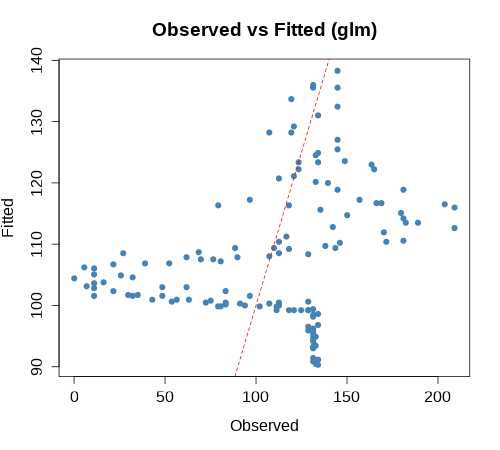

In [14]:
%%R -w 500 -h 450 -u px
# Fitted vs Observed
plot(mcycle$accel_pos, fitted(model_ig),
     main = "Observed vs Fitted (glm)",
     xlab = "Observed", ylab = "Fitted", pch=19, col="steelblue")
abline(0,1, col="red", lty=2)

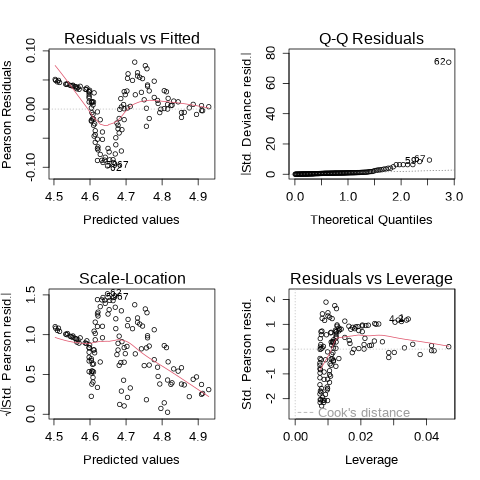

In [15]:
%%R
par(mfrow=c(2,2))
plot(model_ig)  # built-in diagnostic plots

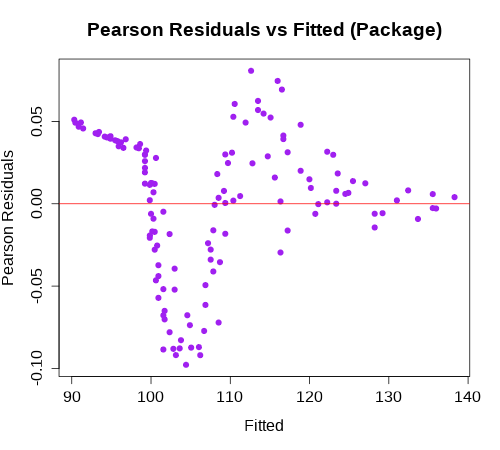

In [17]:
%%R -w 500 -h 450 -u px
res_pearson_pkg <- residuals(model_ig, type = "pearson")
plot(fitted(model_ig), res_pearson_pkg,
     main = "Pearson Residuals vs Fitted (Package)",
     xlab = "Fitted", ylab = "Pearson Residuals", pch=19, col="purple")
abline(h=0, col="red")

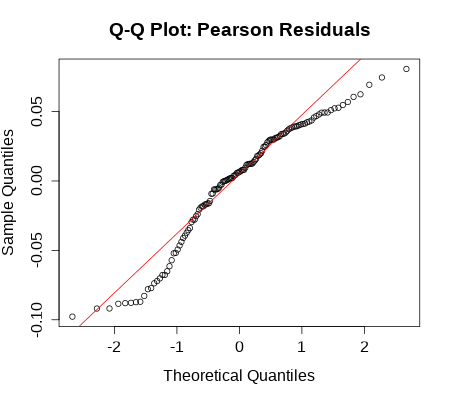

In [18]:
%%R -w 450 -h 400
qqnorm(res_pearson_pkg, main = "Q-Q Plot: Pearson Residuals")
qqline(res_pearson_pkg, col="red")

### Model Performance

In [19]:
%%R
performance::performance(model_ig)

# Indices of model performance

AIC      |     AICc |      BIC |    R2 |   RMSE | Sigma
-------------------------------------------------------
1833.025 | 1833.211 | 1841.696 | 0.089 | 45.938 | 0.043


###  Compare with Scratch Model

You can refit the simulated data using `glm`:

In [20]:
%%R
model_glm <- glm(y ~ x1 + x2,
                 family = inverse.gaussian(link = "log"),
                 data = data_scratch)

summary(model_glm)
cat("Scratch estimates: ", beta_hat, "\n")
cat("glm estimates: ", coef(model_glm), "\n")

Scratch estimates:  0.8907215 0.4660176 -0.2737339 
glm estimates:  0.9674219 0.4713474 -0.2891407 


### Model Selection & AIC

In [21]:
%%R
# Compare with Gamma GLM
model_gamma <- glm(y ~ x1 + x2,
                   family = Gamma(link = "log"),
                   data = data_scratch)

AIC(model_ig)
AIC(model_gamma)

# Lower AIC is better

[1] 1656.69



## Summary and Conclusaion

The Inverse Gaussian GLM is ideal for **right-skewed positive data with variance proportional to the cube of the mean**. While less common than Gamma or lognormal models, it can offer superior fit in specific contexts. This notebook demonstrated how to fit and validate Inverse Gaussian regression models both from scratch using the Newton-Raphson algorithm and using R’s built-in `glm()` function with the `inverse.gaussian` family. At the end, we compared model diagnostics and AIC values to assess fit quality. We  now have a solid understanding of Inverse Gaussian regression modeling in R.

# Resources

- McCullagh, P. and Nelder, J.A. (1989). *Generalized Linear Models*, 2nd Edition.
- R help: `?inverse.gaussian`
- `statmod` package documentation